In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import textdistance
import torch
import warnings

from tqdm.auto import tqdm
from transformers import logging as transformers_logging

import sys
sys.path.insert(0,'../fuzzytext/src')

from fuzzytext import LanguageModel, Extractor

In [2]:
warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

### Download N-grams model trained on Russian rental ads

In [3]:
! mkdir -p models/ngrams/ru_rent_estate_ads
! wget --quiet --no-clobber -P models/ngrams/ru_rent_estate_ads https://github.com/ralan/fuzzytext_models/raw/master/ngrams/ru_rent_estate_ads/2grams.pkl
! wget --quiet --no-clobber -P models/ngrams/ru_rent_estate_ads https://github.com/ralan/fuzzytext_models/raw/master/ngrams/ru_rent_estate_ads/3grams.pkl

### Setup reference context and reference values for rooms number exctracting

In [4]:
reference_context=("сдается * квартира", "сдам * квартиру")

In [5]:
reference_values=[
    {
        "value": "однокомнатная",
        "alternatives": ["1-комнатная"],
    },
    {
        "value": "двухкомнатная",
        "alternatives": ["2-комнатная"],
    },
    {
        "value": "трехкомнатная",
        "alternatives": ["3-комнатная"],
    },
    {
        "value": "четырехкомнатная",
        "alternatives": ["4-комнатная"],
    },
    {
        "value": "пятикомнатная",
        "alternatives": ["5-комнатная"],
    },
]

### Setup rooms number exctractor based on N-grams and Transformers (RoBERTa) models

The RoBERTa model trained on Russian rental ads is located at the Hugging Face public repository (https://huggingface.co/rafagudinov/ru_rent_estate_ads). So it will be automatically downloaded.

In [6]:
lm_roberta = LanguageModel(
    model_type="transformers",
    model_path="rafagudinov/ru_rent_estate_ads",
    device=(0 if torch.cuda.is_available() else -1)
)

fuzzytext_extractor_roberta = Extractor(
    language_model=lm_roberta,
    reference_context=reference_context,
    reference_values=reference_values
)

In [7]:
lm_ngrams = LanguageModel(
    model_type="ngrams",
    model_path="models/ngrams/ru_rent_estate_ads",
    lowercase=True
)

fuzzytext_extractor_ngrams = Extractor(
    language_model=lm_ngrams,
    reference_context=reference_context,
    reference_values=reference_values
)

### Setup baseline rooms number exctractor based on edit distance

In [8]:
def baseline_extractor(text):    
    tokens = re.split(r"\W+", text)

    variants = []

    for i in range(len(tokens)):
        variants.append({"pos": i, "value": tokens[i]})
    
    result = []

    min_distance = float("inf")

    for i in range(len(variants)):
        for reference_value in reference_values:
            values = [reference_value["value"]]

            if reference_value.get("alternatives"):
                values += reference_value["alternatives"]

            for value in values:
                distance = 1 - textdistance.jaro(variants[i]["value"], value)

                if distance < min_distance:
                    min_distance = distance
                    result = []

                if distance > min_distance:
                    continue

                variants[i]["reference_value"] = reference_value["value"]

                result.append(variants[i])

    return result

### Example with a single room number value (no collision)

In [9]:
text_1 = "В аренду предлагается трехком. квартира"

In [10]:
baseline_extractor(text_1)

[{'pos': 3, 'value': 'трехком', 'reference_value': 'трехкомнатная'}]

In [11]:
fuzzytext_extractor_ngrams(text_1)

[{'pos': 3,
  'value': 'трехком',
  'reference_value': 'трехкомнатная',
  'score': 0.8659005002938704}]

In [12]:
fuzzytext_extractor_roberta(text_1)

[{'pos': 3,
  'value': 'трехком',
  'reference_value': 'трехкомнатная',
  'score': 0.8840204958238314}]

### Example with two room number values (collision!)

In [13]:
text_2 = "В аренду предлагается 1к квартира, в которой есть 2к холодильник"

In [14]:
baseline_extractor(text_2)

[{'pos': 3, 'value': '1к', 'reference_value': 'однокомнатная'},
 {'pos': 8, 'value': '2к', 'reference_value': 'двухкомнатная'}]

The baseline extractor can't select the correct value, as it does not take the context into account.

In [15]:
fuzzytext_extractor_ngrams(text_2)

[{'pos': 3,
  'value': '1к',
  'reference_value': 'однокомнатная',
  'score': 0.7680127492799392}]

In [16]:
fuzzytext_extractor_roberta(text_2)

[{'pos': 3,
  'value': '1к',
  'reference_value': 'однокомнатная',
  'score': 0.7930524328850963}]

Both FuzzyText extractors selected the correct value, as they take the context into account.

### Load dataset for tests and metrics

In [17]:
with open("./datasets/ru_rooms_num.json", "r") as fh:
    docs = json.load(fh)
    
docs = docs[:1000]

In [18]:
docs[:5]

[{'text': 'PHONE Сдам однокомн квартиру желательно на длительный срок в центре города. В квартире есть все для комфортного проживания. Вся мебель и техника есть в квартире. Возможно проживание с детьми и / или с животными. Рассмотрю всех платежеспособных.звоните PHONE , фото отправлю в лс.',
  'right_pos': 2,
  'right_token': 'однокомн'},
 {'text': 'Сдаю однокомнатную квартиру на длительный срок. Пирогова 1к3 Мебель и техника все остаются, в рабочем состоянии. 6.500 руб/месяц, залога нет, свет+вода оплачиваются отдельно по счетчикам. Рассматриваю всех желающих. Есть WhаtsАрр. PHONE',
  'right_pos': 1,
  'right_token': 'однокомнатную'},
 {'text': 'Москва, район Восточное Измайлово, 16-я Парковая улица, 19к1. Ближайшее метро Первомайская 6мин.трансп. Сдам 1комн квартиру по отличной цене. Транспорт до метро ходит по расписанию. Ремонт делали для себя. Отремонтированный балкон. 2к холодильник. Имеется стиральная машина. Собственник отдает предпочтение славянам. Строго семейной паре. Стоимо

### Similarity/position scores ratio (*sp_ratio* parameter)

In [19]:
sp_ratio_stat = {}

for extractor_id, extractor in enumerate((fuzzytext_extractor_ngrams, fuzzytext_extractor_roberta)):
    sp_ratio_stat.setdefault(extractor_id, ([], []))

    for sp_ratio in tqdm(np.arange(0, 1, 0.05)):
        right_num = 0

        for doc in docs:
            extractor_result = extractor(doc["text"], sp_ratio=sp_ratio, top_k=5)

            if extractor_result[0]["pos"] == doc["right_pos"]:
                right_num += 1

        sp_ratio_stat[extractor_id][0].append(sp_ratio)
        sp_ratio_stat[extractor_id][1].append(right_num)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

#### N-grams based extractor

<AxesSubplot:>

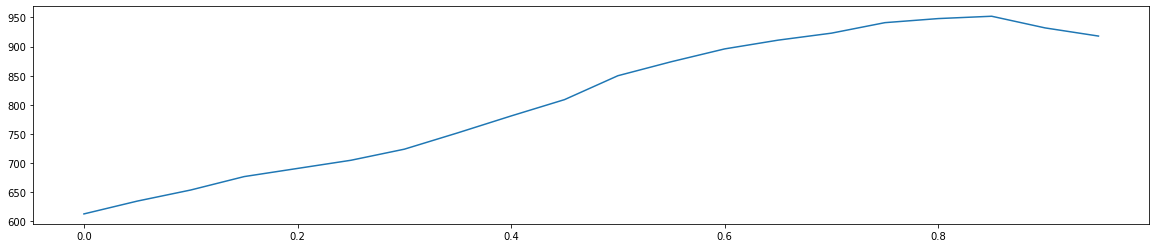

In [20]:
plt.figure(figsize=(20, 4))
sns.lineplot(x=sp_ratio_stat[0][0], y=sp_ratio_stat[0][1])

#### RoBERTa based extractor

<AxesSubplot:>

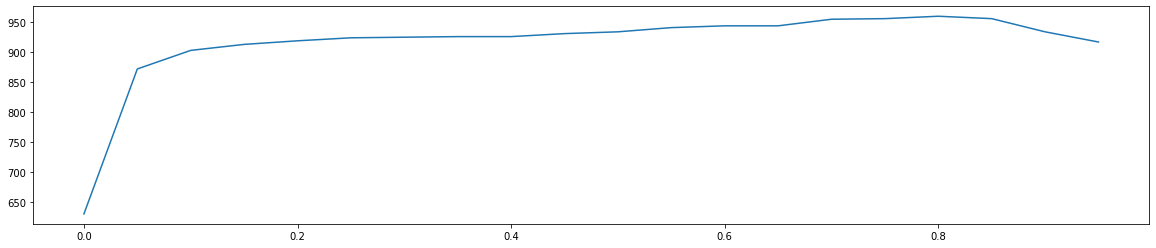

In [21]:
plt.figure(figsize=(20, 4))
sns.lineplot(x=sp_ratio_stat[1][0], y=sp_ratio_stat[1][1])

### Calculate accuracy for the baseline and both FuzzyText extractors (doc level)

In [22]:
def calc_accuracy(extractor):
    right_num = 0
    
    for doc in tqdm(docs):
        results = extractor(doc["text"])
        
        if len(results) != 1:
            continue
            
        if results[0]["pos"] == doc["right_pos"]:
            right_num += 1

    accuracy = right_num / len(docs)
            
    print("Accuracy:", round(accuracy, 2))

#### Baseline extractor

In [23]:
calc_accuracy(baseline_extractor)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.88


#### FuzzyText N-grams based extractor

In [24]:
calc_accuracy(fuzzytext_extractor_ngrams)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.94


#### FuzzyText RoBERTa based extractor

In [25]:
calc_accuracy(fuzzytext_extractor_roberta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.96


### Calculate F1-score for the baseline and both FuzzyText extractors (token level)

In [26]:
def calc_f1_score(extractor):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for doc in tqdm(docs):
        TN += len(re.split(r"\W+", doc["text"]))
        
        results = extractor(doc["text"])
        
        found_right_pos = False
        
        for result in results:            
            if result["pos"] == doc["right_pos"]:
                found_right_pos = True
                TP += 1
                TN -= 1
            else:
                FP += 1
                TN -= 1

        if not found_right_pos:
            FN += 1
            TN -= 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall / (precision + recall))
    
    print("F1-score:", round(f1, 2))

#### Baseline extractor

In [27]:
calc_f1_score(baseline_extractor)

  0%|          | 0/1000 [00:00<?, ?it/s]

F1-score: 0.79


#### FuzzyText N-grams based extractor

In [28]:
calc_f1_score(fuzzytext_extractor_ngrams)

  0%|          | 0/1000 [00:00<?, ?it/s]

F1-score: 0.94


#### FuzzyText RoBERTa based extractor

In [29]:
calc_f1_score(fuzzytext_extractor_roberta)

  0%|          | 0/1000 [00:00<?, ?it/s]

F1-score: 0.96


## Price extracting from fuzzy text

In [30]:
reference_context = "Цена *"
text = "На Ленина 15 сдается квартира, 30000 + ку, звоните: 8(495)1234567"

In [31]:
price_extractor_ngrams = Extractor(
    language_model=lm_ngrams,
    reference_context=reference_context
)

price_extractor_ngrams.extract(text)

[{'pos': 5, 'value': '30000', 'score': 0.7797146228563306}]

In [32]:
price_extractor_roberta = Extractor(
    language_model=lm_roberta,
    reference_context=reference_context
)

price_extractor_roberta.extract(text)

[{'pos': 5, 'value': '30000', 'score': 0.8030004622795116}]